<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/Bidirectional_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMDb dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import keras_tuner as kt

## Data preparation

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
vocab_size = 20000
maxlen = 256

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

##build model

In [ ]:
def build_model(hp):
    model = Sequential()

    # Tuned Hyperparameters
    hp_embed_dim = hp.Int('embed_dim', min_value=32, max_value=128, step=32)
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)
    hp_l2_reg = hp.Choice('l2_reg', values=[1e-3, 1e-4])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 3e-4])

    # Architecture
    model.add(Embedding(vocab_size, hp_embed_dim, input_length=maxlen))
    model.add(SpatialDropout1D(hp_dropout))

    model.add(Bidirectional(LSTM(
        hp_lstm_units,
        return_sequences=True,
        kernel_regularizer=l2(hp_l2_reg),
        recurrent_regularizer=l2(hp_l2_reg)
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Bidirectional(LSTM(
        hp_lstm_units//2,
        kernel_regularizer=l2(hp_l2_reg),
        recurrent_regularizer=l2(hp_l2_reg)
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(hp_l2_reg)))
    model.add(Dropout(hp_dropout/2))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    directory='tuner_dir',
    project_name='imdb_final'
)

## Train model

In [ ]:
tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
    ]
)

Trial 15 Complete [00h 06m 00s]
val_accuracy: 0.8702800273895264

Best val_accuracy So Far: 0.8755199909210205
Total elapsed time: 02h 09m 41s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

Epoch 1/30
196/196 [==============================] - 39s 166ms/step - loss: 0.2091 - accuracy: 0.9346 - val_loss: 0.3444 - val_accuracy: 0.8732 - lr: 3.0000e-04
Epoch 2/30
196/196 [==============================] - 30s 152ms/step - loss: 0.1578 - accuracy: 0.9530 - val_loss: 0.4235 - val_accuracy: 0.8730 - lr: 3.0000e-04
Epoch 3/30
196/196 [==============================] - 29s 147ms/step - loss: 0.1168 - accuracy: 0.9700 - val_loss: 0.4948 - val_accuracy: 0.8596 - lr: 3.0000e-04
Epoch 4/30
196/196 [==============================] - 29s 148ms/step - loss: 0.0918 - accuracy: 0.9796 - val_loss: 0.4639 - val_accuracy: 0.8714 - lr: 1.5000e-04
Epoch 5/30
196/196 [==============================] - 30s 151ms/step - loss: 0.1113 - accuracy: 0.9702 - val_loss: 0.5538 - val_accuracy: 0.8485 - lr: 1.5000e-04
Epoch 6/30
196/196 [==============================] - 29s 149ms/step - loss: 0.0942 - accuracy: 0.9770 - val_loss: 0.5003 - val_accuracy: 0.8691 - lr: 7.5000e-05


## Eval

782/782 [==============================] - 18s 20ms/step
              precision    recall  f1-score   support

           0     0.8847    0.8582    0.8712     12500
           1     0.8623    0.8882    0.8750     12500

    accuracy                         0.8732     25000
   macro avg     0.8735    0.8732    0.8731     25000
weighted avg     0.8735    0.8732    0.8731     25000

              precision    recall  f1-score   support

           0     0.8847    0.8582    0.8712     12500
           1     0.8623    0.8882    0.8750     12500

    accuracy                         0.8732     25000
   macro avg     0.8735    0.8732    0.8731     25000
weighted avg     0.8735    0.8732    0.8731     25000

AUC Score: 0.9469397728


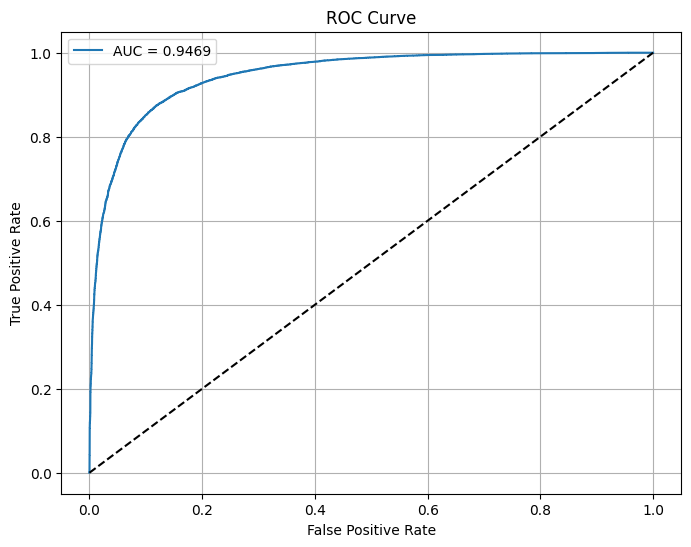

In [ ]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, digits=4))

print(classification_report(y_test, y_pred, digits=4))

auc = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

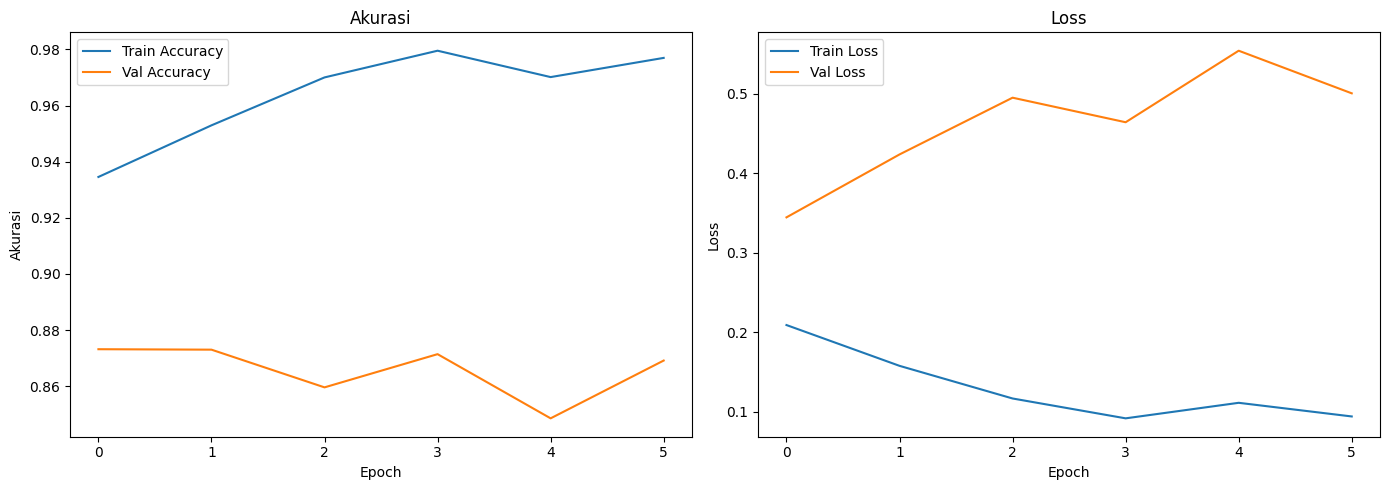

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_acc = best_model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = best_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy: {test_acc*100:.2f}%")


Training Accuracy: 96.89%
Testing Accuracy: 87.32%


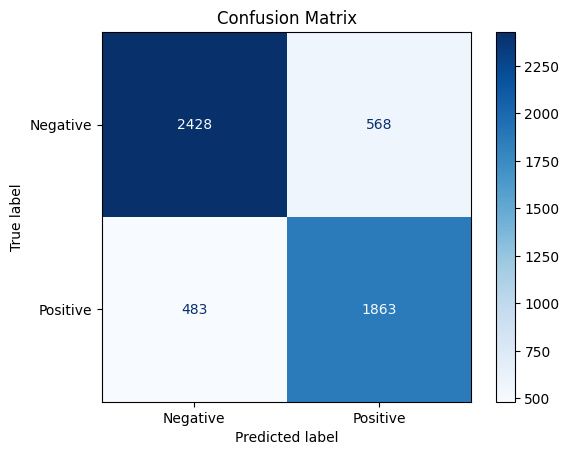

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#ReviewTokoBaju

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras_tuner as kt
import re
import nltk
from nltk.corpus import stopwords

## Data preperation

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maru\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.lower().split()
    text = [word for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

In [ ]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/07.%20Week%207/Datasets/ReviewTokoBaju.csv"
df = pd.read_csv(url)

In [ ]:
print(df.columns.tolist())

['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']


In [ ]:
df['cleaned_review'] = df['Review Text'].apply(clean_text)
df['sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
max_words = 8000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
X = pad_sequences(sequences, maxlen=max_len)
y = df['sentiment'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build model

In [ ]:
def build_model(hp):
    model = Sequential()

    # Tuned hyperparameters
    hp_embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 5e-4])
    hp_l2_reg = hp.Choice('l2_reg', values=[1e-4, 1e-3])

    # Architecture
    model.add(Embedding(max_words, hp_embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(hp_dropout))

    model.add(LSTM(
        hp_lstm_units,
        return_sequences=True,
        kernel_regularizer=l2(hp_l2_reg),
        recurrent_regularizer=l2(hp_l2_reg)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(LSTM(
        hp_lstm_units//2,
        kernel_regularizer=l2(hp_l2_reg),
        recurrent_regularizer=l2(hp_l2_reg)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_regularizer=l2(hp_l2_reg)
    ))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    directory='clothing_review_tuning',
    project_name='sentiment_analysis'
)

## Train Model

In [ ]:
tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
    ]
)

Trial 15 Complete [00h 01m 01s]
val_accuracy: 0.8744146227836609

Best val_accuracy So Far: 0.8759046196937561
Total elapsed time: 00h 37m 19s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

Epoch 1/30
294/294 [==============================] - 13s 33ms/step - loss: 0.2696 - accuracy: 0.9231 - val_loss: 0.5687 - val_accuracy: 0.8440 - lr: 5.0000e-04
Epoch 2/30
294/294 [==============================] - 9s 31ms/step - loss: 0.2300 - accuracy: 0.9394 - val_loss: 0.4548 - val_accuracy: 0.8612 - lr: 5.0000e-04
Epoch 3/30
294/294 [==============================] - 9s 29ms/step - loss: 0.2022 - accuracy: 0.9474 - val_loss: 0.4704 - val_accuracy: 0.8646 - lr: 5.0000e-04
Epoch 4/30
294/294 [==============================] - 9s 32ms/step - loss: 0.2269 - accuracy: 0.9330 - val_loss: 0.4664 - val_accuracy: 0.8348 - lr: 5.0000e-04
Epoch 5/30
294/294 [==============================] - 9s 29ms/step - loss: 0.1938 - accuracy: 0.9474 - val_loss: 0.4777 - val_accuracy: 0.8633 - lr: 2.5000e-04
Epoch 6/30
294/294 [==============================] - 9s 29ms/step - loss: 0.1786 - accuracy: 0.9531 - val_loss: 0.5026 - val_accuracy: 0.8646 - lr: 2.5000e-04
Epoch 7/30
294/294 [===================

## Eval

In [ ]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

147/147 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      1090
           1       0.90      0.93      0.91      3608

    accuracy                           0.86      4698
   macro avg       0.81      0.79      0.80      4698
weighted avg       0.86      0.86      0.86      4698



In [ ]:
train_acc = best_model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = best_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nTraining Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy: {test_acc*100:.2f}%")


Training Accuracy: 93.82%
Testing Accuracy: 86.12%


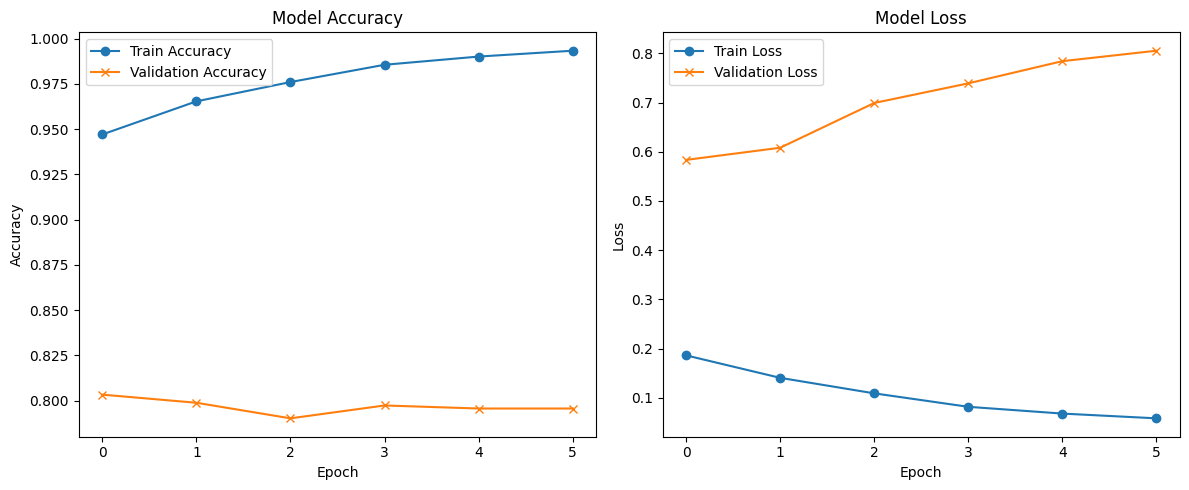

In [29]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

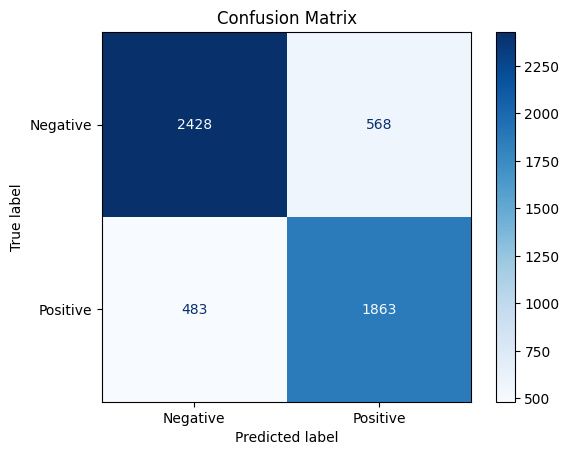

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


#DeteksiSarkasme

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
import json
import re
from nltk.corpus import stopwords
import nltk

## Data Preperation

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/07.%20Week%207/Datasets/DeteksiSarkasme.json"
response = pd.read_json(url, lines=True)
data = response.to_dict('records')

In [4]:
df = pd.json_normalize(data)

In [5]:
print(df.columns)

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')


In [6]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [7]:
df['cleaned_text'] = df['headline'].apply(clean_text)
X = df['cleaned_text']
y = df['is_sarcastic'].values

In [8]:
max_words = 10000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=max_len)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

## Build model

In [11]:
def build_model(hp):
    model = Sequential()

    # Tuned hyperparameters
    hp_embedding_dim = hp.Int('embedding_dim', 64, 256, step=64)
    hp_filters = hp.Int('filters', 32, 128, step=32)
    hp_kernel_size = hp.Choice('kernel_size', [3, 5, 7])
    hp_lstm_units = hp.Int('lstm_units', 32, 128, step=32)
    hp_dropout = hp.Float('dropout', 0.3, 0.6, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    # Architecture
    model.add(Embedding(max_words, hp_embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(hp_dropout))

    # CNN-LSTM Hybrid
    model.add(Conv1D(
        filters=hp_filters,
        kernel_size=hp_kernel_size,
        activation='relu',
        padding='same'
    ))
    model.add(Bidirectional(LSTM(
        hp_lstm_units,
        kernel_regularizer=l2(0.01),
        recurrent_regularizer=l2(0.01)
    )))
    model.add(Dropout(hp_dropout))

    model.add(Dense(
        units=hp.Int('dense_units', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=l2(0.01)
    ))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

In [12]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='sarcasm_tuning',
    project_name='detection'
)

Reloading Tuner from sarcasm_tuning\detection\tuner0.json


## Train Model

In [13]:
tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
    ]
)

Trial 10 Complete [00h 01m 59s]
val_accuracy: 0.8015724420547485

Best val_accuracy So Far: 0.8079370856285095
Total elapsed time: 12h 50m 15s


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [21]:
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

Epoch 1/30
167/167 [==============================] - 11s 46ms/step - loss: 0.1863 - accuracy: 0.9471 - precision: 0.9407 - recall: 0.9386 - val_loss: 0.5835 - val_accuracy: 0.8033 - val_precision: 0.7664 - val_recall: 0.7941 - lr: 0.0010
Epoch 2/30
167/167 [==============================] - 7s 42ms/step - loss: 0.1406 - accuracy: 0.9654 - precision: 0.9613 - recall: 0.9597 - val_loss: 0.6082 - val_accuracy: 0.7988 - val_precision: 0.7676 - val_recall: 0.7771 - lr: 0.0010
Epoch 3/30
167/167 [==============================] - 7s 41ms/step - loss: 0.1091 - accuracy: 0.9760 - precision: 0.9730 - recall: 0.9724 - val_loss: 0.6991 - val_accuracy: 0.7902 - val_precision: 0.7594 - val_recall: 0.7643 - lr: 0.0010
Epoch 4/30
167/167 [==============================] - 7s 42ms/step - loss: 0.0817 - accuracy: 0.9856 - precision: 0.9837 - recall: 0.9835 - val_loss: 0.7391 - val_accuracy: 0.7973 - val_precision: 0.7648 - val_recall: 0.7775 - lr: 5.0000e-04
Epoch 5/30
167/167 [=======================

In [22]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

167/167 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2996
           1       0.77      0.79      0.78      2346

    accuracy                           0.80      5342
   macro avg       0.80      0.80      0.80      5342
weighted avg       0.80      0.80      0.80      5342



## Eval

In [24]:
train_loss, train_acc, train_prec, train_rec = best_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc, test_prec, test_rec = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_acc:.4f} | Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Train Accuracy: 0.9731 | Train Loss: 0.1248
Test Accuracy: 0.8033 | Test Loss: 0.5835


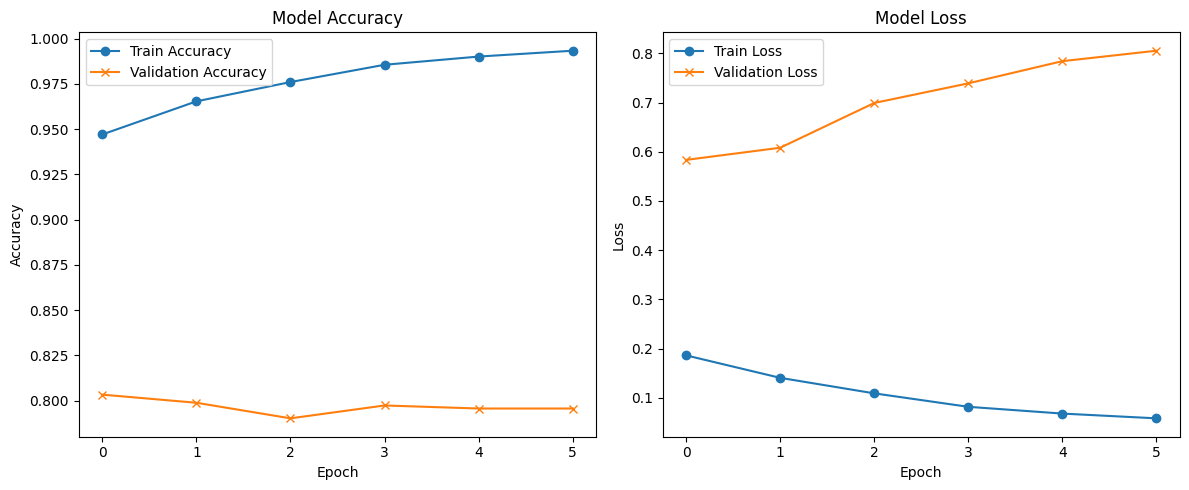

In [25]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

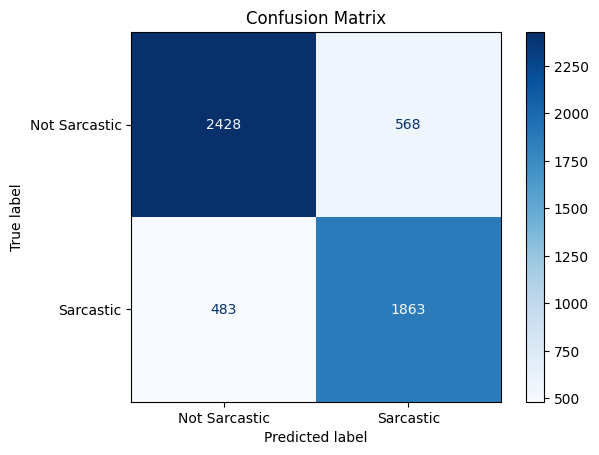

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
